In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb

import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.model_selection import KFold

In [2]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [3]:
features_to_take = ['TransactionID', 'TransactionDT', 'TransactionAmt', 'ProductCD', 'card1', 'card2', 'card3',
                    'card4', 'card5', 'card6', 'addr1', 'addr2', 'dist1', 'dist2', 'P_emaildomain', 'R_emaildomain',
                    'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D2',
                    'D3', 'D4', 'D5', 'D10', 'D11', 'D15', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'V1',
                    'V3', 'V5', 'V7', 'V11', 'V13', 'V14', 'V16', 'V20', 'V24', 'V26', 'V28', 'V30', 'V35', 'V36',
                    'V38', 'V40', 'V41', 'V45', 'V47', 'V49', 'V54', 'V55', 'V56', 'V58', 'V62', 'V65', 'V67', 'V68',
                    'V70', 'V76', 'V78', 'V80', 'V83', 'V87', 'V88', 'V89', 'V91', 'V107', 'V110', 'V112', 'V119',
                    'V121', 'V122', 'V125', 'V131', 'V138', 'V140', 'V142', 'V145', 'V147', 'V162', 'V169', 'V173', 
                    'V174', 'V185', 'V195', 'V210', 'V216', 'V220', 'V222', 'V241', 'V251', 'V271', 'V280', 'V281',
                    'V283', 'V284', 'V286', 'V287', 'V289', 'V291', 'V301', 'V303', 'V305', 'V311', 'V314', 'V323',
                    'V325', 'V335']

features_to_take_id = ['TransactionID', 'id_01', 'id_02', 'id_03', 'id_04', 'id_05', 'id_06', 'id_09', 'id_10',
                       'id_11', 'id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20',
                       'id_28', 'id_29', 'id_30', 'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37',
                       'id_38', 'DeviceType', 'DeviceInfo']

# ID attributes in 
features_to_take_id_test = [feature.replace('_', '-') for feature in features_to_take_id]

# Mention features encoded to a particular dtype
string_features_train = ['ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain', 'M4', 'id_12', 'id_15',
                         'id_16', 'id_28', 'id_29', 'id_30', 'id_31', 'id_33', 'id_34', 'DeviceType', 'DeviceInfo']

string_features_test = [feature.replace('_', '-') for feature in string_features_train]

boolean_features = ['M' + str(i) for i in range(1, 10) if i != 4] + ['id_' + str(i) for i in range(35, 39)]

In [4]:
# Read train and test dataset
train_df = pd.read_csv('../dataset/train_transaction.csv', usecols=features_to_take + ['isFraud'])
test_df = pd.read_csv('../dataset/test_transaction.csv', usecols=features_to_take)

train_df_id = pd.read_csv('../dataset/train_identity.csv', usecols=features_to_take_id)
test_df_id = pd.read_csv('../dataset/test_identity.csv', usecols=features_to_take_id_test)

# Left join dataset
train_df = train_df.merge(right=train_df_id, how='left', on='TransactionID')
test_df = test_df.merge(right=test_df_id, how='left', on='TransactionID')

In [5]:
renaming_mapper = dict(zip(features_to_take_id_test, features_to_take_id))
test_df.rename(mapper=renaming_mapper, axis='columns', inplace=True)

In [6]:
le = preprocessing.LabelEncoder()

concat_df = pd.concat([train_df, test_df])

for feature in string_features_train:
    train_df[feature] = train_df[feature].astype('str')
    test_df[feature] = test_df[feature].astype('str')
    concat_df[feature] = concat_df[feature].astype('str')
    le.fit(concat_df[feature])
    train_df[feature] = le.fit_transform(train_df[feature])
    test_df[feature] = le.fit_transform(test_df[feature])
    
for feature in boolean_features:
    train_df[feature] = train_df[feature].astype('bool')
    test_df[feature] = test_df[feature].astype('bool')

In [7]:
train_df.head(n=3)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D2,D3,D4,D5,D10,D11,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V3,V5,V7,V11,V13,V14,V16,V20,V24,V26,V28,V30,V35,V36,V38,V40,V41,V45,V47,V49,V54,V55,V56,V58,V62,V65,V67,V68,V70,V76,V78,V80,V83,V87,V88,V89,V91,V107,V110,V112,V119,V121,V122,V125,V131,V138,V140,V142,V145,V147,V162,V169,V173,V174,V185,V195,V210,V216,V220,V222,V241,V251,V271,V280,V281,V283,V284,V286,V287,V289,V291,V301,V303,V305,V311,V314,V323,V325,V335,id_01,id_02,id_03,id_04,id_05,id_06,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,4,13926,NaN,150.0,1,142.0,1,315.0,87.0,19.0,NaN,32,32,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,NaN,13.0,NaN,NaN,13.0,13.0,0.0,True,True,True,2,True,True,True,True,True,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,3,2,NaN,NaN,NaN,NaN,2,2,74,103,NaN,260,4,True,True,True,True,2,1742
1,2987001,0,86401,29.0,4,2755,404.0,150.0,2,102.0,1,325.0,87.0,NaN,NaN,16,32,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,NaN,NaN,0.0,NaN,0.0,NaN,0.0,True,True,True,0,True,True,True,True,True,NaN,NaN,NaN,NaN,NaN,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,3,2,NaN,NaN,NaN,NaN,2,2,74,103,NaN,260,4,True,True,True,True,2,1742
2,2987002,0,86469,59.0,4,4663,490.0,150.0,4,166.0,2,330.0,87.0,287.0,NaN,36,32,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,NaN,NaN,0.0,NaN,0.0,315.0,315.0,True,True,True,0,True,True,True,True,True,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,3,2,NaN,NaN,NaN,NaN,2,2,74,103,NaN,260,4,True,True,True,True,2,1742


In [8]:
test_df.head(n=3)

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D2,D3,D4,D5,D10,D11,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V3,V5,V7,V11,V13,V14,V16,V20,V24,V26,V28,V30,V35,V36,V38,V40,V41,V45,V47,V49,V54,V55,V56,V58,V62,V65,V67,V68,V70,V76,V78,V80,V83,V87,V88,V89,V91,V107,V110,V112,V119,V121,V122,V125,V131,V138,V140,V142,V145,V147,V162,V169,V173,V174,V185,V195,V210,V216,V220,V222,V241,V251,V271,V280,V281,V283,V284,V286,V287,V289,V291,V301,V303,V305,V311,V314,V323,V325,V335,id_01,id_02,id_03,id_04,id_05,id_06,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,3663549,18403224,31.95,4,10409,111.0,150.0,4,226.0,2,170.0,87.0,1.0,NaN,16,32,6.0,6.0,0.0,0.0,3.0,4.0,0.0,0.0,6.0,0.0,5.0,1.0,115.0,6.0,419.0,27.0,398.0,27.0,418.0,203.0,409.0,True,True,True,3,True,True,True,True,True,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,3,2,NaN,NaN,NaN,NaN,2,2,85,107,NaN,390,2,True,True,True,True,2,2184
1,3663550,18403263,49.00,4,4272,111.0,150.0,4,226.0,2,299.0,87.0,4.0,NaN,2,32,3.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,1.0,1.0,12.0,2.0,149.0,7.0,634.0,7.0,231.0,634.0,634.0,True,True,True,0,True,True,True,True,True,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,77.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,3,2,NaN,NaN,NaN,NaN,2,2,85,107,NaN,390,2,True,True,True,True,2,2184
2,3663551,18403310,171.00,4,4476,574.0,150.0,4,226.0,2,472.0,87.0,2635.0,NaN,19,32,2.0,2.0,0.0,0.0,0.0,5.0,0.0,0.0,4.0,0.0,2.0,0.0,22.0,2.0,137.0,10.0,97.0,10.0,136.0,136.0,97.0,True,True,True,0,True,True,True,True,True,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,2.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,2.0,2.0,0.0,2.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,3,2,NaN,NaN,NaN,NaN,2,2,85,107,NaN,390,2,True,True,True,True,2,2184


In [9]:
# Generate k-fold Cross Validation
n_fold = 5
folds = KFold(n_splits=5)

columns = train_df.columns

In [10]:
# Params
n_estimators_list = [1000, 1500]
max_depth_list = [8, 12, 16, 20]
subsample_list = [0.7, 0.8, 0.9]
colsample_bytree_list = [0.4, 0.5, 0.6]

In [ ]:
# k-fold Cross Validation
for n_estimators in n_estimators_list:
    for max_depth in max_depth_list:
        for subsample in subsample_list:
            for colsample_bytree in colsample_bytree_list:
                for fold_n, (train_index, valid_index) in enumerate(folds.split(train_df)):
                    if type(train_df) == np.ndarray:
                        X_train, X_valid = train_df[columns][train_index], train_df[columns][valid_index]
                    else:
                        X_train, X_valid = train_df[columns].iloc[train_index], train_df[columns].iloc[valid_index]

                    model = xgb.XGBClassifier( 
                        n_estimators=n_estimators,
                        max_depth=max_depth, 
                        learning_rate=0.02, 
                        subsample=subsample,
                        colsample_bytree=colsample_bytree, 
                        eval_metric='auc',
                        tree_method='hist'
                    )

                    print("Fold " + str(fold_n + 1))
                    print("n_estimators: " + str(n_estimators))
                    print("max_depth: " + str(max_depth))
                    print("subsample: " + str(subsample))
                    print("colsample_bytree: " + str(colsample_bytree))
                    
                    h = model.fit(X_train.loc[:, X_train.columns != 'isFraud'], X_train['isFraud'], 
                                eval_set=[(X_valid.loc[:, train_df.columns != 'isFraud'], X_valid['isFraud'])],
                                verbose=50, early_stopping_rounds=100)

In [11]:
model = xgb.XGBClassifier( 
        missing=np.NaN,
        n_estimators=2000,
        max_depth=16, 
        learning_rate=0.02,
        subsample=0.8,
        colsample_bytree=0.4, 
        eval_metric='auc',
        tree_method='hist'
    )

train_idx = train_df.index[:4*len(train_df)//5]
valid_idx = train_df.index[4*len(train_df)//5:]

if type(train_df) == np.ndarray:
    X_train, X_valid = train_df[columns][train_idx], train_df[columns][valid_idx]
else:
    X_train, X_valid = train_df[columns].iloc[train_idx], train_df[columns].iloc[valid_idx]

h = model.fit(X_train.loc[:, train_df.columns != 'isFraud'], X_train['isFraud'], 
    eval_set=[(X_valid.loc[:, train_df.columns != 'isFraud'], X_valid['isFraud'])],
    verbose=50, early_stopping_rounds=100)

[0]	validation_0-auc:0.823917
Will train until validation_0-auc hasn't improved in 100 rounds.
[50]	validation_0-auc:0.874158
[100]	validation_0-auc:0.887264
[150]	validation_0-auc:0.897589
[200]	validation_0-auc:0.907236
[250]	validation_0-auc:0.913739
[300]	validation_0-auc:0.918331
[350]	validation_0-auc:0.921345
[400]	validation_0-auc:0.922528
[450]	validation_0-auc:0.922978
[500]	validation_0-auc:0.922728
[550]	validation_0-auc:0.922739
Stopping. Best iteration:
[450]	validation_0-auc:0.922978



In [12]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if not normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [13]:
g = model.predict_proba(X_valid.loc[:, X_valid.columns != 'isFraud'])

118108


<Figure size 432x288 with 0 Axes>

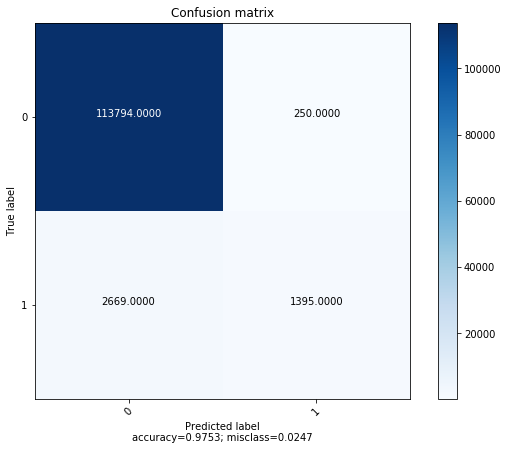

In [14]:
from sklearn.metrics import confusion_matrix
g_bin = 1*(g[:, 1]>0.5)
print(len(g_bin))
unique, counts = np.unique(g_bin, return_counts=True)
cm = confusion_matrix(X_valid['isFraud'], g_bin)
plt.figure()
plot_confusion_matrix(cm, [0,1])
plt.show()

In [ ]:
f = model.predict_proba(test_df.loc[:, test_df.columns != 'isFraud'])

In [ ]:
result_df = pd.DataFrame({
    "TransactionID": test_df.TransactionID, 
    "isFraud": f[:, 1]})

In [ ]:
result_df.to_csv("xgboost.csv", index=False)